# PJM Marginal Fuel Study

Analysis of marginal fuel on PJM over the past decade using public data from PJM and Monitoring Analytics.  We focus particularly on the % of wind and solar offered on the margin and are looking for any growth in these sources relative to fossil as marginal producer.  Study is to support our  effort in helping scope out the size of future curtailed excess generated renewable power available for grid-connected "green" loads. 

Started 1/12/2023 (david.t.wang@atlanticshoreswind.com)
Python 3.9.13 

In [65]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import pytz #timezones library


In [17]:
# Create array of filenames from PJM website.  These filenames are in the format:
# 202209_Marginal_Fuel_Postings.csv
#
# Data go back to 200401_ ...

filenames = []

for i in np.arange(2004,2024):
    for j in np.arange(1,13):
        filenames.append("%04.0f%02.0f_Marginal_Fuel_Postings.csv" % (i,j))



# 12*(i-2004)+j-1)      '{:4.0f}{:2.0f}'.format)




In [37]:
# WGET and import monthly PJM data into pandas dataframe
# 
# These files are located at:
# http://www.monitoringanalytics.com/data/marginal_fuel_type/202208_Marginal_Fuel_Postings.csv

urlprefix = 'http://www.monitoringanalytics.com/data/marginal_fuel_type/'
urls = [urlprefix + s for s in filenames]

pjmdat = pd.DataFrame() #([], headers=['RUN','HOUR','MMS_TIMEZONE','FUEL_TYPE','PERCENT_MARGINAL'])

for i in range(len(urls)):
    try:
        tmpdf = pd.read_csv(urls[i])
        pjmdat = pd.concat([pjmdat, tmpdf])
    except:
        print("File %s does not exist." % (filenames[i]))


pjmdat.to_hdf('pjmdat.h5', key='pjmdat')
pjmdat.to_csv('pjmdat.csv')
pjmdat

# CSV files contain: 
# RUN	HOUR	            MMS_TIMEZONE	FUEL_TYPE	PERCENT_MARGINAL
# str   DDMMMYYYY:HH:MM:SS  str             str         fraction of 1


File 202210_Marginal_Fuel_Postings.csv does not exist.
File 202211_Marginal_Fuel_Postings.csv does not exist.
File 202212_Marginal_Fuel_Postings.csv does not exist.
File 202301_Marginal_Fuel_Postings.csv does not exist.
File 202302_Marginal_Fuel_Postings.csv does not exist.
File 202303_Marginal_Fuel_Postings.csv does not exist.
File 202304_Marginal_Fuel_Postings.csv does not exist.
File 202305_Marginal_Fuel_Postings.csv does not exist.
File 202306_Marginal_Fuel_Postings.csv does not exist.
File 202307_Marginal_Fuel_Postings.csv does not exist.
File 202308_Marginal_Fuel_Postings.csv does not exist.
File 202309_Marginal_Fuel_Postings.csv does not exist.
File 202310_Marginal_Fuel_Postings.csv does not exist.
File 202311_Marginal_Fuel_Postings.csv does not exist.
File 202312_Marginal_Fuel_Postings.csv does not exist.


C:\Users\DavidTWang\AppData\Local\Temp\ipykernel_28112\1247113153.py:19: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['mms_datetime', 'MMS_TIMEZONE', 'fuel_type', 'percent_marginal',
       'run_date', 'mms_timezone', 'FUEL_TYPE', 'HOUR', 'RUN'],
      dtype='object')]

  pjmdat.to_hdf('pjmdat.h5', key='pjmdat')


,mms_datetime,MMS_TIMEZONE,fuel_type,percent_marginal,run_date,audit_key,mms_timezone,PERCENT_MARGINAL,FUEL_TYPE,HOUR,RUN
0,01JAN04:00:00:00,EST,COAL,100.00%,20APR2006:10:38:00,202326.0,NaN,NaN,NaN,NaN,NaN
1,01JAN04:01:00:00,EST,COAL,100.00%,20APR2006:10:38:00,202326.0,NaN,NaN,NaN,NaN,NaN
2,01JAN04:02:00:00,EST,COAL,100.00%,20APR2006:10:38:00,202326.0,NaN,NaN,NaN,NaN,NaN
3,01JAN04:03:00:00,EST,COAL,100.00%,20APR2006:10:38:00,202326.0,NaN,NaN,NaN,NaN,NaN
4,01JAN04:04:00:00,EST,COAL,100.00%,20APR2006:10:38:00,202326.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1391,NaN,EDT,NaN,NaN,NaN,NaN,NaN,1.0000,Natural Gas,30SEP2022:20:00:00,PRICING
1392,NaN,EDT,NaN,NaN,NaN,NaN,NaN,0.9231,Natural Gas,30SEP2022:21:00:00,PRICING
1393,NaN,EDT,NaN,NaN,NaN,NaN,NaN,0.0769,Coal,30SEP2022:21:00:00,PRICING
1394,NaN,EDT,NaN,NaN,NaN,NaN,NaN,1.0000,Natural Gas,30SEP2022:22:00:00,PRICING


In [148]:
# read from saved data to save server call
pjmdat = pd.read_csv('pjmdat.csv', index_col=[0])

# clean duplicate columns and merge to eliminate NaN's
margfueldf = pd.DataFrame() # initalize empty df
margfueldf['DATETIME'] = pjmdat['mms_datetime'].fillna(pjmdat['HOUR']).astype('str')
margfueldf['TIMEZONE'] = pjmdat['MMS_TIMEZONE'].fillna(pjmdat['mms_timezone']).astype('str')
margfueldf['FUEL'] = pjmdat['fuel_type'].fillna(pjmdat['FUEL_TYPE']).astype('str')
margfueldf['PCT_MARGINAL'] = (pjmdat['percent_marginal'].str.replace('%', 'e-2').astype(float)).fillna(pjmdat['PERCENT_MARGINAL'])


C:\Users\DavidTWang\AppData\Local\Temp\ipykernel_28112\844856454.py:2: DtypeWarning: Columns (1,3,4,5,7,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  pjmdat = pd.read_csv('pjmdat.csv', index_col=[0])


In [149]:
# create dtdf, a DST-naive Series of datetimes in EST or EDT
dtdf = pd.to_datetime(margfueldf['DATETIME'], format="%d%b%Y:%H:%M:%S", errors="coerce").fillna(pd.to_datetime(margfueldf['DATETIME'], format="%d%b%y:%H:%M:%S", errors="coerce"))

# function to determine whether to correct the nominal UTC times by 1 hour when DST is in effect
def zoneoffsetfunc(pddatetime, tzname):
    adder = {'EST': 0, 'EDT': -1} #dict to match EST/EDT to offset value in hours
    return pddatetime + pd.Timedelta(hours=adder[tzname])

# now add +4 hours to convert to UTC, keeping in mind that times that were in EDT are -1 hour behind
dtdf_UTC = dtdf + pd.Timedelta(hours=4)
tempdf = pd.concat([dtdf_UTC, margfueldf['TIMEZONE']], axis=1)

# apply zoneoffsetfunc to every row in df
tempdf['DATETIME_UTC'] = tempdf.apply(lambda x: zoneoffsetfunc(x['DATETIME'], x['TIMEZONE']), axis=1)


In [150]:
# put UTC datetime column to margfueldf and drop the original columns
margfueldf['DATETIME_UTC'] = tempdf['DATETIME_UTC']
margfueldf.drop(['DATETIME', 'TIMEZONE'], axis=1, inplace=True)
margfueldf = margfueldf[['DATETIME_UTC', 'FUEL', 'PCT_MARGINAL']]

In [151]:
# clean up the fuel types by grouping them
tempdf = pd.read_csv('fueltypes_mapping.csv', index_col=[0])
mapping = dict(tempdf[['original','lumped']].values)
margfueldf['FUEL'] = margfueldf['FUEL'].map(mapping)
margfueldf

# set index on datetime
margfueldf.set_index('DATETIME_UTC', inplace=True)

,DATETIME_UTC,FUEL,PCT_MARGINAL
0,2004-01-01 04:00:00,coal,1.0000
1,2004-01-01 05:00:00,coal,1.0000
2,2004-01-01 06:00:00,coal,1.0000
3,2004-01-01 07:00:00,coal,1.0000
4,2004-01-01 08:00:00,coal,1.0000
...,...,...,...
1391,2022-09-30 23:00:00,gas,1.0000
1392,2022-10-01 00:00:00,gas,0.9231
1393,2022-10-01 00:00:00,coal,0.0769
1394,2022-10-01 01:00:00,gas,1.0000


FUEL
DR             AxesSubplot(0.125,0.2;0.775x0.68)
MGE            AxesSubplot(0.125,0.2;0.775x0.68)
battery        AxesSubplot(0.125,0.2;0.775x0.68)
biogas         AxesSubplot(0.125,0.2;0.775x0.68)
biomass        AxesSubplot(0.125,0.2;0.775x0.68)
coal           AxesSubplot(0.125,0.2;0.775x0.68)
gas            AxesSubplot(0.125,0.2;0.775x0.68)
hydro          AxesSubplot(0.125,0.2;0.775x0.68)
imported       AxesSubplot(0.125,0.2;0.775x0.68)
misc           AxesSubplot(0.125,0.2;0.775x0.68)
nuclear        AxesSubplot(0.125,0.2;0.775x0.68)
oil            AxesSubplot(0.125,0.2;0.775x0.68)
solar          AxesSubplot(0.125,0.2;0.775x0.68)
unknown        AxesSubplot(0.125,0.2;0.775x0.68)
virtualsale    AxesSubplot(0.125,0.2;0.775x0.68)
wind           AxesSubplot(0.125,0.2;0.775x0.68)
Name: PCT_MARGINAL, dtype: object

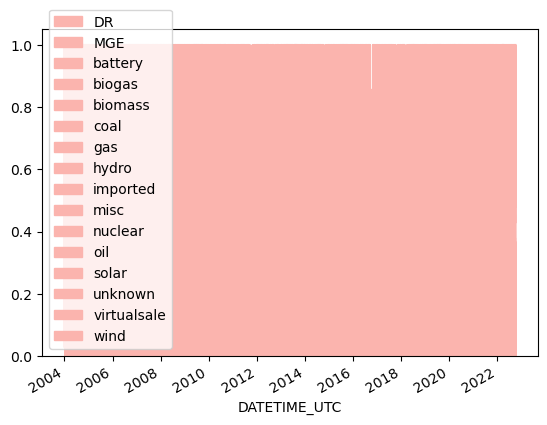

In [157]:
# plotting
margfueldf.groupby('FUEL')['PCT_MARGINAL'].plot(kind='area', legend=True, colormap="Pastel1")

<AxesSubplot:xlabel='DATETIME_UTC'>

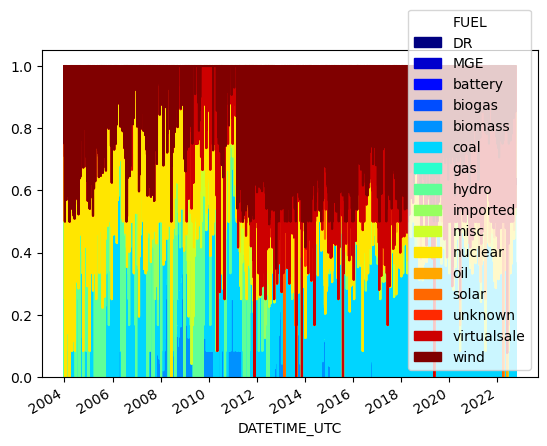

In [164]:
df = pd.pivot_table(margfueldf.reset_index(), values='PCT_MARGINAL', 
    index=['DATETIME_UTC'], columns=['FUEL'])



<AxesSubplot:xlabel='DATETIME_UTC'>

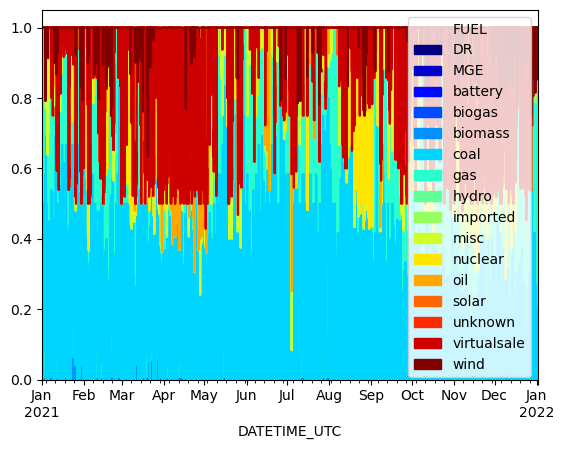

In [169]:
# i = pd.date_range(start='2021-01-01',end='2022-01-01')
df.loc['2021-01-01':'2022-01-01'].plot.area(colormap='jet')

<AxesSubplot:xlabel='DATETIME_UTC'>

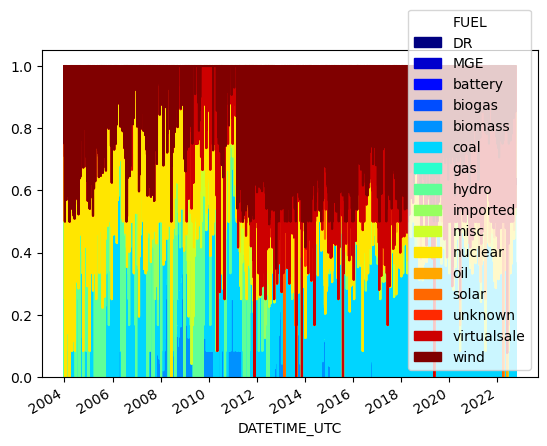

In [168]:
df.plot.area(colormap='jet')

<AxesSubplot:title={'center':'%WIND on margin'}, xlabel='DATETIME_UTC'>

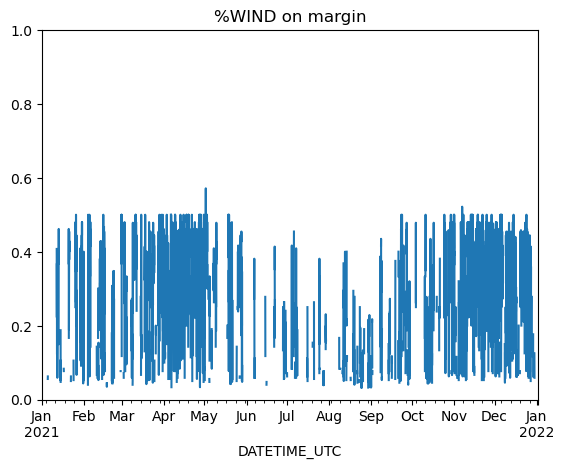

In [175]:
df.loc['2021-01-01':'2022-01-01']['wind'].plot(ylim=[0,1], title="%WIND on the margin")

In [137]:
fueltypesSeries = pd.Series(margfueldf['FUEL'].unique())
fueltypesSeries.to_csv('fueltypes.csv')

In [136]:
margfueldf[margfueldf['FUEL']=='nan']

,FUEL,PCT_MARGINAL
DATETIME_UTC,,
2004-01-09 10:00:00,nan,0.1250
2004-01-09 14:00:00,nan,0.2500
2004-01-09 15:00:00,nan,0.0833
2004-01-17 00:00:00,nan,0.0556
2006-02-15 09:00:00,nan,0.0278
2006-05-01 08:00:00,nan,0.1944
2006-05-01 09:00:00,nan,0.0278
2006-05-04 13:00:00,nan,0.0278
2006-05-04 14:00:00,nan,0.0556


In [141]:
margfueldf[margfueldf['FUEL']=='Min Gen/Dispatch Reset']

,FUEL,PCT_MARGINAL
DATETIME_UTC,,
2012-12-04 03:00:00,Min Gen/Dispatch Reset,NaN
2012-12-05 03:00:00,Min Gen/Dispatch Reset,NaN
2012-12-05 05:00:00,Min Gen/Dispatch Reset,NaN
2012-12-25 07:00:00,Min Gen/Dispatch Reset,NaN
2013-01-30 02:00:00,Min Gen/Dispatch Reset,0.1667
...,...,...
2019-06-16 10:00:00,Min Gen/Dispatch Reset,0.3333
2019-06-23 07:00:00,Min Gen/Dispatch Reset,0.3333
2019-06-23 08:00:00,Min Gen/Dispatch Reset,0.3333
